In [1]:
!pip install nibabel
!pip install medicaltorch

In [2]:
#@title Default title text
import numpy as np
import numbers
import torchvision.transforms.functional as F
from torchvision import transforms
from PIL import Image
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter
import torchvision.transforms.functional

class MTTransform(object):

    def __call__(self, sample):
        raise NotImplementedError("You need to implement the transform() method.")

    def undo_transform(self, sample):
        raise NotImplementedError("You need to implement the undo_transform() method.")


class UndoCompose(object):
    def __init__(self, compose):
        self.transforms = compose.transforms

    def __call__(self):
        for t in self.transforms:
            img = t.undo_transform(img)
        return img


class UndoTransform(object):
    def __init__(self, transform):
        self.transform = transform

    def __call__(self, sample):
        return self.transform.undo_transform(sample)


class ToTensor(MTTransform):
    """Convert a PIL image or numpy array to a PyTorch tensor."""

    def __init__(self, labeled=True):
        self.labeled = labeled

    def __call__(self, sample):
        rdict = {}
        input_data = sample['input']

        if isinstance(input_data, list):
            ret_input = [F.to_tensor(item)
                         for item in input_data]
        else:
            ret_input = F.to_tensor(input_data)

        rdict['input'] = ret_input

        if self.labeled:
            gt_data = sample['gt']
            if gt_data is not None:
                if isinstance(gt_data, list):
                    ret_gt = [F.to_tensor(item)
                              for item in gt_data]
                else:
                    ret_gt = F.to_tensor(gt_data)

                rdict['gt'] = ret_gt

        sample.update(rdict)
        return sample


class ToPIL(MTTransform):
    def __init__(self, labeled=True):
        self.labeled = labeled

    def sample_transform(self, sample_data):
        # Numpy array
        if not isinstance(sample_data, np.ndarray):
            input_data_npy = sample_data.numpy()
        else:
            input_data_npy = sample_data

        input_data_npy = np.transpose(input_data_npy, (1, 2, 0))
        input_data_npy = np.squeeze(input_data_npy, axis=2)
        input_data = Image.fromarray(input_data_npy, mode='F')
        return input_data

    def __call__(self, sample):
        rdict = {}
        input_data = sample['input']

        if isinstance(input_data, list):
            ret_input = [self.sample_transform(item)
                         for item in input_data]
        else:
            ret_input = self.sample_transform(input_data)

        rdict['input'] = ret_input

        if self.labeled:
            gt_data = sample['gt']

            if isinstance(gt_data, list):
                ret_gt = [self.sample_transform(item)
                          for item in gt_data]
            else:
                ret_gt = self.sample_transform(gt_data)

            rdict['gt'] = ret_gt

        sample.update(rdict)
        return sample


class res(MTTransform):
    """Make a center crop of a specified size.

    :param segmentation: if it is a segmentation task.
                         When this is True (default), the crop
                         will also be applied to the ground truth.
    """
    def __init__(self, size, labeled=True):
        self.size = size
        self.labeled = labeled

    @staticmethod
    def propagate_params(sample, params):
        input_metadata = sample['input_metadata']
        input_metadata["__centercrop"] = params
        return input_metadata

    @staticmethod
    def get_params(sample):
        input_metadata = sample['input_metadata']
        return input_metadata["__centercrop"]

    def __call__(self, sample):
        rdict = {}
        input_data = sample['input']

        w, h = input_data.size
        th, tw = self.size
        fh = int(round((h - th) / 2.))
        fw = int(round((w - tw) / 2.))

        params = (fh, fw, w, h)
        self.propagate_params(sample, params)

        input_data = torchvision.transforms.functional.resize(input_data, self.size)
        rdict['input'] = input_data

        if self.labeled:
            gt_data = sample['gt']
            gt_metadata = sample['gt_metadata']
            gt_data = torchvision.transforms.functional.resize(gt_data, self.size)
            gt_metadata["__centercrop"] = (fh, fw, w, h)
            rdict['gt'] = gt_data


        sample.update(rdict)
        return sample

    def undo_transform(self, sample):
        rdict = {}
        input_data = sample['input']
        fh, fw, w, h = self.get_params(sample)
        th, tw = self.size

        pad_left = fw
        pad_right = w - pad_left - tw
        pad_top = fh
        pad_bottom = h - pad_top - th

        padding = (pad_left, pad_top, pad_right, pad_bottom)
        input_data = F.pad(input_data, padding)
        rdict['input'] = input_data

        sample.update(rdict)
        return sample







In [3]:
# for custom dataset class
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms
import glob
import nibabel as nib
import os
from medicaltorch import datasets as mt_datasets
from medicaltorch import transforms as mt_transforms
import matplotlib.pyplot as plt
from google.colab import drive
import torch.nn as nn
import math

In [4]:
drive.mount('/gdrive')
ROOT_DIR = "/gdrive/My Drive/MM-WHS 2017 Dataset/"
# ROOT_DIR = 'drive/MyDrive/MM-WHS 2017 Dataset/'
mri_input_filename = os.path.join(ROOT_DIR,'ct_train',
                                          'ct_train_1001_image.nii.gz')
mri_gt_filename = os.path.join(ROOT_DIR,'ct_train',
                                          'ct_train_1001_label.nii.gz')

pair = mt_datasets.SegmentationPair2D(mri_input_filename, mri_gt_filename)
slice_pair = pair.get_pair_slice(159)
input_slice = slice_pair["input"]
gt_slice = slice_pair["gt"]

Mounted at /gdrive


(512, 512)


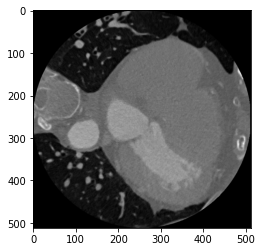

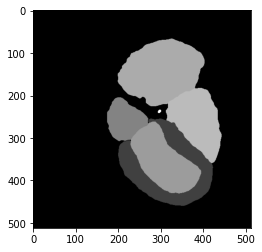

(512, 512, 363)

In [5]:
print(input_slice.shape)
img = input_slice
plt.imshow(img,cmap = 'gray')
plt.show()
img = gt_slice
plt.imshow(img,cmap = 'gray')
plt.show()

img_data,seg_data = pair.get_pair_data()
img_data.shape
seg_data.shape

In [6]:
# img_list = os.listdir(os.path.join(ROOT_DIR,'mr_train'))
# label_list = os.listdir(os.path.join(ROOT_DIR,'labelsTr'))
img_list = sorted(glob.glob(os.path.join(ROOT_DIR, "mr_train")+"/*image.nii.gz"))
label_list = sorted(glob.glob(os.path.join(ROOT_DIR, "mr_train")+"/*label.nii.gz"))

In [7]:
# filename_pairs = [(glob.glob(os.path.join(ROOT_DIR, "mr_train")+"/*image.nii.gz",x),glob.glob(os.path.join(ROOT_DIR, "mr_train")+"/*label.nii.gz",y)) for x,y in zip(img_list,label_list)]
filename_pairs = [(os.path.join(ROOT_DIR,'mr_train',x),os.path.join(ROOT_DIR,'mr_train',y)) for x,y in zip(img_list,label_list)]
# filename_pairs

In [8]:
# img_list = os.listdir(os.path.join(ROOT_DIR,'mr_train'))
# label_list = os.listdir(os.path.join(ROOT_DIR,'labelsTr'))
img_list2 = sorted(glob.glob(os.path.join(ROOT_DIR, "ct_train")+"/*image.nii.gz"))
label_list2 = sorted(glob.glob(os.path.join(ROOT_DIR, "ct_train")+"/*label.nii.gz"))

filename_pairs2 = [(os.path.join(ROOT_DIR,'ct_train',x),os.path.join(ROOT_DIR,'ct_train',y)) for x,y in zip(img_list2,label_list2)]


In [9]:
from torchvision import transforms, utils
from skimage import io, transform

train_transform = transforms.Compose([

        # transforms.Resize((256,256)),
        # transforms.ToPILImage(),
        # transforms.ToTensor()
        res((128,128)),
        mt_transforms.ToTensor()
        
        ]
)

train_dataset = mt_datasets.MRI2DSegmentationDataset(filename_pairs,transform=train_transform)
train_dataset2= mt_datasets.MRI2DSegmentationDataset(filename_pairs2,transform=train_transform)

type(train_dataset)
print(len(train_dataset))

# sample of the training dataset
train_dataset[0]
train_dataset2[0]
# print(type(train_dataset[0]))

2898


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:132: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  img = torch.from_numpy(np.array(pic, np.float32, copy=False))


{'gt': tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 'gt_metadata': <medicaltorch.datasets.SampleMetadata at 0x7f25333e0ad0>,
 'input': tensor([[[-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
          [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
          [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
          ...,
          [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
          [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
          [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.]]]),
 'input_metadata': <medicaltorch.datasets.SampleMetadata at 0x7f25217e70d0>}

In [10]:
# PyTorch data loader
from torch.utils.data import DataLoader

dataloader = DataLoader(train_dataset, batch_size=1,collate_fn=mt_datasets.mt_collate)
# batch = next(iter(dataloader))
dataloader2= DataLoader(train_dataset2, batch_size=1, collate_fn=mt_datasets.mt_collate)

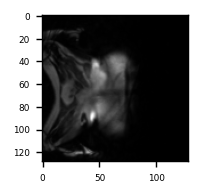

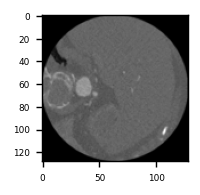

In [11]:
import matplotlib
matplotlib.rcParams.update({'font.size': 5})
for _ in range(1):
    for i, batch in enumerate(zip(dataloader, dataloader2)):
      # GAN loss
        # fake_B = G_AB(real_A)

        # print(fake_B[0].shape)
        # print(batch[0]["input"][0].shape)
        plt.figure(figsize = (1.5,1.5), dpi=128)
        plt.imshow(batch[0]["input"][0].detach().cpu().permute(1,2,0)[:,:,0],cmap = 'gray')
        plt.tight_layout()
        plt.show()

        plt.figure(figsize = (1.5,1.5), dpi=128)
        plt.imshow(batch[1]["input"][0].detach().cpu().permute(1,2,0)[:,:,0],cmap = 'gray')
        plt.tight_layout()
        plt.show()

        # plt.imshow(batch[0]["gt"][0].detach().cpu().permute(1,2,0)[:,:,0],cmap = 'gray')
        # plt.show()

        break

In [12]:
# for i,b in enumerate(dataloader):
#     print(b['input'].size())
#     break

for i,b in enumerate(zip(dataloader, dataloader2)):
    # print(b[0])
    # print('222')
    print(b[0]["input"].shape)
    break
    # assert b[0]['input'].size()[2]==256
    # assert b[0]['input'].size()[3]==256

    # print(b['input'].size())

torch.Size([1, 1, 128, 128])


In [13]:
# print(batch['input'].size())
# for item in batch['input']:
#     plt.imshow(item.squeeze(0),cmap = 'gray')

#     plt.show()

In [14]:
class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()

        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features),
        )

    def forward(self, x):
        return x + self.block(x)

        

  
class Discriminator(nn.Module):
    def __init__(self, input_shape):
        super(Discriminator, self).__init__()

        channels, height, width = input_shape

        # Calculate output shape of image discriminator (PatchGAN)
        self.output_shape = (1, height // 2 ** 4, width // 2 ** 4)

        def discriminator_block(in_filters, out_filters, normalize=True):
            """Returns downsampling layers of each discriminator block"""
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *discriminator_block(channels, 32, normalize=False),
            *discriminator_block(32, 64),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(256, 1, 4, padding=1)
        )

    def forward(self, img):
        return self.model(img)

  
class LambdaLR:
    def __init__(self, n_epochs, offset, decay_start_epoch):
        assert (n_epochs - decay_start_epoch) > 0, "Decay must start before the training session ends!"
        self.n_epochs = n_epochs
        self.offset = offset
        self.decay_start_epoch = decay_start_epoch

    def step(self, epoch):
        return 1.0 - max(0, epoch + self.offset - self.decay_start_epoch) / (self.n_epochs - self.decay_start_epoch)

class ReplayBuffer:
    def __init__(self, max_size=50):
        assert max_size > 0, "Empty buffer or trying to create a black hole. Be careful."
        self.max_size = max_size
        self.data = []

    def push_and_pop(self, data):
        to_return = []
        for element in data.data:
            element = torch.unsqueeze(element, 0)
            if len(self.data) < self.max_size:
                self.data.append(element)
                to_return.append(element)
            else:
                if random.uniform(0, 1) > 0.5:
                    i = random.randint(0, self.max_size - 1)
                    to_return.append(self.data[i].clone())
                    self.data[i] = element
                else:
                    to_return.append(element)
        return Variable(torch.cat(to_return))

In [15]:
'''
visualize images
'''
def vis(image):
    plt.imshow(image[0].detach().cpu().permute(1,2,0)[:,:,0],cmap='gray')
    plt.show()
  # for _ in range(10):
      # for i, batch in enumerate(zip(dataloader, dataloader2)):
        # GAN loss
          # fake_B = G_AB(real_A)

          # print(fake_B[0].shape)
          
          # plt.imshow(fake_B[0].detach().cpu().permute(1,2,0)[:,:,0],cmap = 'gray')
          # plt.show()

          # break

In [16]:
# https://discuss.pytorch.org/t/implementing-truncated-normal-initializer/4778/21
# https://github.com/tensorflow/tensorflow/blob/85c8b2a817f95a3e979ecd1ed95bff1dc1335cff/tensorflow/python/ops/random_ops.py#L163
# def parameterized_truncated_normal(uniform, mu=0.0, sigma=1.0, a, b):
#     normal = torch.distributions.normal.Normal(0, 1)

#     alpha = (a - mu) / sigma
#     beta = (b - mu) / sigma

#     alpha_normal_cdf = normal.cdf(alpha)
#     p = alpha_normal_cdf + (normal.cdf(beta) - alpha_normal_cdf) * uniform

#     p = p.numpy()
#     one = np.array(1, dtype=p.dtype)
#     epsilon = np.array(np.finfo(p.dtype).eps, dtype=p.dtype)
#     v = np.clip(2 * p - 1, -one + epsilon, one - epsilon)res
#     x = mu + sigma * np.sqrt(2) * torch.erfinv(torch.from_numpy(v))
#     x = torch.clamp(x, a, b)

#     return x


# def truncated_normal(uniform):
#     return parameterized_truncated_normal(uniform, mu=0.0, sigma=1.0, a=-2, b=2)
def truncated_normal(t, mean=0.0, std=0.01):
    torch.nn.init.normal_(t, mean=mean, std=std)
    while True:
      cond = torch.logical_or(t < mean - 2*std, t > mean + 2*std)
      if not torch.sum(cond):
        break
      t = torch.where(cond.cuda(), torch.nn.init.normal_(torch.ones(t.shape), mean=mean, std=std).cuda(), t.cuda()).cuda()
      
    # return t

def compute_conv_output(H, K, S):
  return int(((H-K+2*0)/S)+1)

def compute_padding(out, H, K, S):
  return int((S*(out-1)-H+K)/2)

def compute_padding_deconv(out, H, K, S):
  return int((-out+(H-1)*S+K)/2)

def compute_maxpool_padding(S, H, f):
  '''
  H2=(H1-f)/s+1
  '''
  return int((S*(H-1)-H+f)/2)


In [17]:

class General_Conv2D(nn.Module):
    # @torch.no_grad()
    def init_weights(self, n):
      if type(n) == nn.Conv2d:
          truncated_normal(n.weight, 0.01)
          

    def __init__(self, in_features=0, out_features=64, k=7, s=1, stddev=0.01, do_relu=True, keep_rate=0.75, relu_factor=0, norm_type=None, train=True, padding=False, input_dim=0):
        super(General_Conv2D, self).__init__()
        self.std=stddev
        self.keep_rate=keep_rate
        self.relu_factor=relu_factor
        self.norm_type=norm_type
        self.do_relu=do_relu
        self.k=k
        self.s=s
        self.padding=padding

        self.dropout = nn.Dropout(p=keep_rate)
        
        if norm_type=='Batch':
          if train:
            self.batchnorm=nn.BatchNorm2d(num_features=out_features, momentum=0.1, affine=True).train()
          else:
            self.batchnorm=nn.BatchNorm2d(num_features=out_features, momentum=0.1, affine=True)
        elif norm_type=='Ins':
          if train:
            self.instancenorm=nn.InstanceNorm2d(num_features=out_features).train()
          else:
            self.instancenorm=nn.InstanceNorm2d(num_features=out_features)
        
        self.relu=nn.ReLU()
        self.lrealu=nn.LeakyReLU()
        
        self.w= nn.Parameter(torch.randn(out_features, in_features, k,k))
        truncated_normal(self.w)
        self.b=nn.Parameter(torch.randn(out_features))

    def forward(self, x):

        '''
        initialize weights
        '''
        
        if self.padding==False:
          x = torch.nn.functional.conv2d(x, self.w, self.b, padding=0)

        else:
          
          x = torch.nn.functional.conv2d(x, self.w, self.b, padding=compute_padding(x.shape[-1], x.shape[-1], self.k, self.s))
        
        '''
        dropout
        '''
        if not self.keep_rate is None:
          x=self.dropout(x)

        '''
        norm
        '''
        if (self.norm_type=='Batch'):
          x=self.batchnorm(x)
        else:# Instance norm
          x=self.instancenorm(x)

        '''
        act fnc
        '''
        if (self.do_relu==True):
          if (self.relu_factor==0):
            x=self.relu(x)
          else:
            x=self.lrealu(x)
        
        '''
        update global dim
        '''
        global dim
        dim=x.shape[-1]

        return x

        # return x + self.block(x)


class Resnet_Block(nn.Module):
    def __init__(self, in_features, out_features , padding="REFLECT", norm_type=None, keep_rate=0.75):
        super(Resnet_Block, self).__init__()

        if padding=='REFLECT':
          pad_layer=nn.ReflectionPad2d(1)
        elif padding=='CONSTANT':
          pad_layer=nn.ZeroPad2d(1)
        else: # SYMMETRIC
          pad_layer=nn.ReplicationPad2d(1)

        self.block = nn.Sequential(
            pad_layer,
            General_Conv2D(in_features, out_features, k=3, s=1, stddev=0.01, norm_type=norm_type, keep_rate=keep_rate, padding=False),
            pad_layer,
            General_Conv2D(in_features, out_features, k=3, s=1, stddev=0.01, do_relu=False, norm_type=norm_type, keep_rate=keep_rate, padding=False)
        )

        # self.l1=nn.ReflectionPad2d(1)
        # self.l2=General_Conv2D(in_features, out_features, k=3, s=1, stddev=0.01, norm_type=norm_type, keep_rate=keep_rate, padding='VALID')
        # self.l3=nn.ReflectionPad2d(1)
        # self.l4=General_Conv2D(in_features, out_features, k=3, s=1, stddev=0.01, do_relu=False, norm_type=norm_type, keep_rate=keep_rate, padding='VALID')

        self.relu=nn.ReLU()

    def forward(self, x):
        # print(x.shape)
        # x=self.l1(x)
        # print(x.shape)
        # x=self.l2(x)
        # print(x.shape)
        # x=self.l3(x)
        # print(x.shape)
        # x=self.l4(x)
        # print(x.shape)

        # print(x.shape)
        out = self.block(x)
        # print(out.shape)

        return self.relu(out+x)

class Resnet_Block_ds(nn.Module):
    def __init__(self, in_features=0, out_features=0, padding="REFLECT",dim=0, norm_type=None, keep_rate=0.75):
        super(Resnet_Block_ds, self).__init__()

        self.in_features=in_features
        self.out_features=out_features

        if padding=='REFLECT':
          pad_layer=nn.ReflectionPad2d(1)
        elif padding=='CONSTANT':
          pad_layer=nn.ZeroPad2d(1)
        else: # SYMMETRIC
          pad_layer=nn.ReplicationPad2d(1)


        self.block = nn.Sequential(
            
            pad_layer,
            General_Conv2D(in_features, out_features, k=3, s=1, stddev=0.01, norm_type=norm_type, keep_rate=keep_rate, padding=False),
            pad_layer,
            General_Conv2D(out_features, out_features, k=3, s=1, stddev=0.01, do_relu=False, norm_type=norm_type, keep_rate=keep_rate, padding=False)
        )

    def forward(self, x):
     
        out = self.block(x)
        '''
        pad channel dim
        '''
        pd=(self.out_features-self.in_features) // 2

        padding = torch.zeros(x.shape[0], pd, x.shape[2], x.shape[3]).cuda()
        padded_inp = torch.cat((x, padding), 1)
        padded_inp = torch.cat((padding, padded_inp), 1)


        return torch.nn.functional.relu(out+padded_inp)
  
class drn_Block(nn.Module):
    def __init__(self, in_features, keep_rate=0.75):
        super(drn_Block, self).__init__()

        self.block = nn.Sequential(
            nn.ReflectionPad2d(2),
            nn.Conv2d(in_features, in_features, 3, dilation=2),
            nn.Dropout(0.75),
            nn.BatchNorm2d(in_features),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(2),
            nn.Conv2d(in_features, in_features, 3, dilation=2),
            nn.Dropout(0.75),
            nn.BatchNorm2d(in_features),
        )

    def forward(self, x):
        x = x + self.block(x)
        

        return torch.nn.functional.relu(x)


class General_Conv2D_GA(nn.Module):
    # @torch.no_grad()
    def init_weights(self, n):
      if type(n) == nn.Conv2d:
          truncated_normal(n.weight, 0.02)
          

    def __init__(self, in_features=0, out_features=64, k=7, s=1, stddev=0.02, do_relu=True, keep_rate=0.75, relu_factor=0, norm_type=None, train=True, padding=False, input_dim=0):
        super(General_Conv2D_GA, self).__init__()
        self.std=stddev
        self.keep_rate=keep_rate
        self.relu_factor=relu_factor
        self.norm_type=norm_type
        self.do_relu=do_relu
        self.k=k
        self.s=s
        self.padding=padding

        self.dropout = nn.Dropout(p=keep_rate)
        
        if norm_type=='Batch':
          if train:
            self.batchnorm=nn.BatchNorm2d(num_features=out_features, momentum=0.1, affine=True).train()
          else:
            self.batchnorm=nn.BatchNorm2d(num_features=out_features, momentum=0.1, affine=True)
        elif norm_type=='Ins':
          if train:
            self.instancenorm=nn.InstanceNorm2d(num_features=out_features).train()
          else:
            self.instancenorm=nn.InstanceNorm2d(num_features=out_features)
        
        self.relu=nn.ReLU()
        self.lrealu=nn.LeakyReLU()
        
        self.w= nn.Parameter(torch.randn(out_features, in_features, k,k))
        truncated_normal(self.w)
        self.b=nn.Parameter(torch.randn(out_features))
        torch.nn.init.constant_(self.b, 0)

    def forward(self, x):

        '''
        initialize weights
        '''
        
        print('GA')
        print(x.shape)

        if self.padding==False:
          x = torch.nn.functional.conv2d(x, self.w, self.b, padding=0)

        else:
          
          x = torch.nn.functional.conv2d(x, self.w, self.b, padding=compute_padding(x.shape[-1], x.shape[-1], self.k, self.s))
        
        '''
        dropout
        '''
        if not self.keep_rate is None:
          x=self.dropout(x)

        '''
        norm
        '''
        if (self.norm_type=='Batch'):
          x=self.batchnorm(x)
        elif self.norm_type=='Ins':# Instance norm
          x=self.instancenorm(x)

        '''
        act fnc
        '''
        if (self.do_relu==True):
          if (self.relu_factor==0):
            x=self.relu(x)
          else:
            x=self.lrealu(x)
        
       

        return x

        # return x + self.block(x)


class Resnet_Block_ins(nn.Module):
    def __init__(self, in_features=0, out_features=0, padding="REFLECT",dim=0, norm_type=None, keep_rate=0.75):
        super(Resnet_Block_ins, self).__init__()

        self.in_features=in_features
        self.out_features=out_features

        if padding=='REFLECT':
          pad_layer=nn.ReflectionPad2d(1)
        elif padding=='CONSTANT':
          pad_layer=nn.ZeroPad2d(1)
        else: # SYMMETRIC
          pad_layer=nn.ReplicationPad2d(1)


        self.block = nn.Sequential(
            
            pad_layer,
            General_Conv2D_GA(in_features, out_features, k=3, s=1, stddev=0.02, norm_type='Ins', keep_rate=keep_rate, padding=False, do_relu=True),
            pad_layer,
            General_Conv2D_GA(out_features, out_features, k=3, s=1, stddev=0.02, norm_type='Ins', keep_rate=keep_rate, padding=False, do_relu=False)
        )

    def forward(self, x):
     
        out = self.block(x)
        
        return torch.nn.functional.relu(out+x)

class General_Deconv2D(nn.Module):
    # @torch.no_grad()
    def init_weights(self, n):
      if type(n) == nn.Conv2d:
          truncated_normal(n.weight, 0.02)
          

    def __init__(self, in_features=0, out_features=64, k=7, s=1, stddev=0.02, do_relu=True, keep_rate=0.75, relu_factor=0, norm_type=None, train=True, padding=False, input_dim=0, out_shape=0):
        super(General_Deconv2D, self).__init__()
        self.std=stddev
        self.keep_rate=keep_rate
        self.relu_factor=relu_factor
        self.norm_type=norm_type
        self.do_relu=do_relu
        self.k=k
        self.s=s
        self.padding=padding
        self.out_shape=out_shape
        
        if norm_type=='Batch':
          if train:
            self.batchnorm=nn.BatchNorm2d(num_features=out_features, momentum=0.1, affine=True).train()
          else:
            self.batchnorm=nn.BatchNorm2d(num_features=out_features, momentum=0.1, affine=True)
        elif norm_type=='Ins':
          if train:
            self.instancenorm=nn.InstanceNorm2d(num_features=out_features).train()
          else:
            self.instancenorm=nn.InstanceNorm2d(num_features=out_features)
        
        self.relu=nn.ReLU()
        self.lrealu=nn.LeakyReLU()
        
        self.w= nn.Parameter(torch.randn(in_features, out_features, k,k))
        truncated_normal(self.w)
        self.b=nn.Parameter(torch.randn(out_features))
        torch.nn.init.constant_(self.b, 0)

    def forward(self, x):

        '''
        initialize weights
        '''

        print('deconv')
        print(x.shape)

        if self.padding==False:
          x = torch.nn.functional.conv_transpose2d(x, self.w, bias=self.b, stride=self.s, padding=0)
          # x = torch.nn.functional.conv2d(x, self.w, self.b, padding=0)

        else:
          x = torch.nn.functional.conv_transpose2d(x, self.w, bias=self.b, stride=self.s, padding=compute_padding_deconv(self.out_shape, x.shape[-1], self.k, self.s))
          # x = torch.nn.functional.conv2d(x, self.w, self.b, padding=compute_padding(x.shape[-1], x.shape[-1], self.k, self.s))
        

        '''
        norm
        '''
        if (self.norm_type=='Batch'):
          x=self.batchnorm(x)
        else:# Instance norm
          x=self.instancenorm(x)

        '''
        act fnc
        '''
        if (self.do_relu==True):
          if (self.relu_factor==0):
            x=self.relu(x)
          else:
            x=self.lrealu(x)


        'explicit resize'
        # x=torch.reshape(x, (x.shape[0], x.shape[1], x.shape[2]-1, x.shape[3]-1))
        x=x[:,:,:self.out_shape,:self.out_shape]
        

        return x

        # return x + self.block(x)

In [18]:
class GeneratorResNet(nn.Module):
    def __init__(self, skip=True):
        super(GeneratorResNet, self).__init__()

        self.skip=skip
        # self.input_img=input_img
        self.block = nn.Sequential(
            nn.ZeroPad2d(3),
            General_Conv2D_GA(in_features=1, out_features=32, k=7, s=1, stddev=0.02, do_relu=True, norm_type='Ins', train=True, padding=False),
            General_Conv2D_GA(in_features=32, out_features=32*2, k=3, s=2, stddev=0.02, do_relu=True, norm_type='Ins', train=True, padding=True),
            General_Conv2D_GA(in_features=32*2, out_features=32*4, k=3, s=2, stddev=0.02, do_relu=True, norm_type='Ins', train=True, padding=True),
            Resnet_Block_ins(in_features=32*4, out_features=32*4, padding='CONSTANT'),
            Resnet_Block_ins(in_features=32*4, out_features=32*4, padding='CONSTANT'),
            Resnet_Block_ins(in_features=32*4, out_features=32*4, padding='CONSTANT'),
            Resnet_Block_ins(in_features=32*4, out_features=32*4, padding='CONSTANT'),
            Resnet_Block_ins(in_features=32*4, out_features=32*4, padding='CONSTANT'),
            Resnet_Block_ins(in_features=32*4, out_features=32*4, padding='CONSTANT'),
            Resnet_Block_ins(in_features=32*4, out_features=32*4, padding='CONSTANT'),
            Resnet_Block_ins(in_features=32*4, out_features=32*4, padding='CONSTANT'),
            Resnet_Block_ins(in_features=32*4, out_features=32*4, padding='CONSTANT'),
            General_Deconv2D(in_features=32*4, out_features=32*2, k=3, s=2, stddev=0.02, norm_type='Ins', out_shape=64, padding=True),
            General_Deconv2D(in_features=32*2, out_features=32, k=3, s=2, stddev=0.02, norm_type='Ins', out_shape=128, padding=True),
            General_Conv2D_GA(in_features=32, out_features=1, k=7, s=1, stddev=0.02, do_relu=False, train=True, padding=True),
            )
        

    def forward(self, x):
      out=self.block(x)
      if self.skip==True:
        
        return torch.nn.functional.tanh(x+out)
      else:
        return torch.nn.functional.tanh(out)




In [19]:
'''
input shape: B,C,H,W
'''
class EncoderNet(nn.Module):
    def __init__(self, train, input_shape):
        super(EncoderNet, self).__init__()
        self.train=train
        self.input_shape=input_shape

  

        self.out_c1 = General_Conv2D(in_features=1, out_features=16, padding=True, train=self.train, input_dim=self.input_shape[-1], norm_type='Batch')
        self.out_res1 = Resnet_Block(in_features=16,out_features=16,norm_type='Batch')
        self.out1 = nn.MaxPool2d(kernel_size=1, stride=1, padding=compute_maxpool_padding(S=1, H=input_shape[-1], f=1))
        
        self.out_res2 = Resnet_Block_ds(in_features=16, out_features=16*2, norm_type='Batch', padding='CONSTANT')
        # self.out2 = nn.MaxPool2d(kernel_size=1, stride=1, padding=compute_maxpool_padding(S=1, H=input_shape[-1], f=1))

        self.out_res3 = Resnet_Block_ds(in_features=16*2, out_features=16*4, norm_type='Batch', padding='CONSTANT')
        self.out_res4 = Resnet_Block(in_features=16*4,out_features=16*4,norm_type='Batch', padding='CONSTANT')
        # self.out3 = nn.MaxPool2d(kernel_size=1, stride=1, padding=compute_maxpool_padding(S=1, H=input_shape[-1], f=1))

        self.out_res5 = Resnet_Block_ds(in_features=16*4,out_features=16*8,norm_type='Batch', padding='CONSTANT')
        self.out_res6 = Resnet_Block(in_features=16*8,out_features=16*8,norm_type='Batch', padding='CONSTANT')

        self.out_res7 = Resnet_Block_ds(in_features=16*8,out_features=16*16,norm_type='Batch', padding='CONSTANT')
        self.out_res8 = Resnet_Block(in_features=16*16,out_features=16*16,norm_type='Batch', padding='CONSTANT')

        self.out_res9 = Resnet_Block(in_features=16*16,out_features=16*16,norm_type='Batch', padding='CONSTANT')
        self.out_res10= Resnet_Block(in_features=16*16,out_features=16*16,norm_type='Batch', padding='CONSTANT')

        self.out_res11= Resnet_Block_ds(in_features=16*16,out_features=16*32,norm_type='Batch', padding='CONSTANT')
        self.out_res12= Resnet_Block(in_features=16*32,out_features=16*32,norm_type='Batch', padding='CONSTANT')

        self.out_drn1 = drn_Block(in_features=16*32)
        self.out_drn2 = drn_Block(in_features=16*32)
        '''
        use global dim below !!
        '''
        self.out_c2 = General_Conv2D(in_features=16*32, out_features=16*32, k=3, padding=True, train=self.train, input_dim=0, norm_type='Batch')
        self.out_c3 = General_Conv2D(in_features=16*32, out_features=16*32, k=3, padding=True, train=self.train, input_dim=0, norm_type='Batch')


    def forward(self, x):
        # x = General_Conv2D(in_features=3, out_features=16, padding='SAME', train=self.train, input_dim=self.input_dim, norm_type='Batch')(x)
        # x = Resnet_Block(in_features=x.shape[1],out_features=out,norm_type='BATCH')(x)
        '''
        separate kernel size implementation from tf not available in pytorch
        TODO
        '''
  #       def compute_maxpool_padding(S, H, f):
  # return (S*(H-1)-H+f)/2
        
        # x = nn.MaxPool2D(kernel_size=1, stride=1, padding=compute_maxpool_padding(S=1, H=x.shape[-1], f=1))

        # x = Resnet_Block_ds(in_features=x.shape[1], out_features=16*2, dim=16, norm_type='Batch', padding='CONSTANT')(X)
        x=self.out_c1(x)
        x=self.out_res1(x)
        x=self.out1(x)
        x=self.out_res2(x)
        self.out2 = nn.MaxPool2d(kernel_size=1, stride=1, padding=compute_maxpool_padding(S=1, H=x.shape[-1], f=1))
        x=self.out2(x)
        x=self.out_res3(x)
        x=self.out_res4(x)
        self.out3 = nn.MaxPool2d(kernel_size=1, stride=1, padding=compute_maxpool_padding(S=1, H=x.shape[-1], f=1))
        x=self.out3(x)
        x=self.out_res5(x)
        x=self.out_res6(x)
        x=self.out_res7(x)
        x=self.out_res8(x)
        x=self.out_res9(x)
        x=self.out_res10(x)
       
        x=self.out_res11(x)
        x=self.out_res12(x)
        y=x
        x=self.out_drn1(x)
        x=self.out_drn2(x)
        '''
        '''
        x=self.out_c2(x)
        x=self.out_c3(x)

        return x, y

In [20]:
# class DecoderNet(nn.Module):
# class DecoderNet(nn.Module):
#     def __init__(self, input_shape, num_residual_blocks):
#         super(GeneratorResNet, self).__init__()

#         channels = input_shape[0]

#         # Initial convolution block
#         # out_features = 64
#         out_features=32
#         model = [
#             nn.ReflectionPad2d(3),
#             nn.Conv2d(channels, out_features, 7),
#             nn.InstanceNorm2d(out_features),
#             nn.ReLU(inplace=True),
#         ]
#         in_features = out_features

#         # Downsampling
#         for _ in range(2):
#             out_features *= 2
#             model += [
#                 nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
#                 nn.InstanceNorm2d(out_features),
#                 nn.ReLU(inplace=True),
#             ]
#             in_features = out_features

#         # Residual blocks
#         for _ in range(num_residual_blocks):
#             model += [ResidualBlock(out_features)]

#         # Upsampling
#         for _ in range(2):
#             out_features //= 2
#             model += [
#                 nn.Upsample(scale_factor=2),
#                 nn.Conv2d(in_features, out_features, 3, stride=1, padding=1),
#                 nn.InstanceNorm2d(out_features),
#                 nn.ReLU(inplace=True),
#             ]
#             in_features = out_features

#         # Output layer
#         model += [nn.ReflectionPad2d(3), nn.Conv2d(out_features, channels, 7), nn.Tanh()]

#         self.model = nn.Sequential(*model)

#     def forward(self, x):
#         return self.model(x)

In [21]:
import argparse
import os
import numpy as np
import math
import itertools
import datetime
import time

import torchvision.transforms as transforms
from torchvision.utils import save_image, make_grid

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable



# from utils import *

import torch.nn as nn
import torch.nn.functional as F
import torch
import sys
import random

# Losses
criterion_GAN = torch.nn.MSELoss()
criterion_cycle = torch.nn.L1Loss()
criterion_identity = torch.nn.L1Loss()

cuda = torch.cuda.is_available()


# Initialize generator and discriminator

# G_AB = GeneratorResNet((1, 128, 128), 9)
# G_BA = GeneratorResNet((1, 128, 128), 9)
D_A = Discriminator((1, 128, 128))
D_B = Discriminator((1, 128, 128))

'''
Encoder
'''
# Encoder = EncoderNet(train=True, input_shape=(2,1,128,128))
'''
Decoder
'''
# Decoder = DecoderNet()

if cuda:
    # Encoder = Encoder.cuda()
    # G_AB = G_AB.cuda()
    # G_BA = G_BA.cuda()
    D_A = D_A.cuda()
    D_B = D_B.cuda()
    criterion_GAN.cuda()
    criterion_cycle.cuda()
    criterion_identity.cuda()

opt={"lr":0.0002,"b1":0.5, "b2":0.999, "epoch":0, "n_epochs":10, "decay_epoch":5, "lambda_cyc":10.0, "lambda_id":5.0}

# # Optimizers
# optimizer_G = torch.optim.Adam(
#     itertools.chain(G_AB.parameters(), G_BA.parameters()), lr=opt["lr"], betas=(opt["b1"], opt["b2"])
# )
# optimizer_D_A = torch.optim.Adam(D_A.parameters(), lr=opt["lr"], betas=(opt["b1"], opt["b2"]))
# optimizer_D_B = torch.optim.Adam(D_B.parameters(), lr=opt["lr"], betas=(opt["b1"], opt["b2"]))

# # Learning rate update schedulers
# lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(
#     optimizer_G, lr_lambda=LambdaLR(opt["n_epochs"], opt["epoch"], opt["decay_epoch"]).step
# )
# lr_scheduler_D_A = torch.optim.lr_scheduler.LambdaLR(
#     optimizer_D_A, lr_lambda=LambdaLR(opt["n_epochs"], opt["epoch"], opt["decay_epoch"]).step
# )
# lr_scheduler_D_B = torch.optim.lr_scheduler.LambdaLR(
#     optimizer_D_B, lr_lambda=LambdaLR(opt["n_epochs"], opt["epoch"], opt["decay_epoch"]).step
# )

Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor

# fake_A_buffer = ReplayBuffer()
# fake_B_buffer = ReplayBuffer()

# def sample_images(batches_done):
#     """Saves a generated sample from the test set"""
#     imgs = next(iter(val_dataloader))
#     G_AB.eval()
#     G_BA.eval()
#     real_A = Variable(imgs["A"].type(Tensor))
#     fake_B = G_AB(real_A)
#     real_B = Variable(imgs["B"].type(Tensor))
#     fake_A = G_BA(real_B)
#     # Arange images along x-axis
#     real_A = make_grid(real_A, nrow=5, normalize=True)
#     real_B = make_grid(real_B, nrow=5, normalize=True)
#     fake_A = make_grid(fake_A, nrow=5, normalize=True)
#     fake_B = make_grid(fake_B, nrow=5, normalize=True)
#     # Arange images along y-axis
#     image_grid = torch.cat((real_A, fake_B, real_B, fake_A), 1)
#     save_image(image_grid, "images/%s/%s.png" % (opt.dataset_name, batches_done), normalize=False)


# ----------
#  Training
# ----------

prev_time = time.time()
for epoch in range(opt["epoch"], opt["n_epochs"]):
    for i, batch in enumerate(zip(dataloader, dataloader2)):

        # Set model input
        real_A = Variable(batch[0]["input"].type(Tensor)) # mri
        real_B = Variable(batch[1]["input"].type(Tensor)) # ct

        # Adversarial ground truths
        valid = Variable(Tensor(np.ones((real_A.size(0), *D_A.output_shape))), requires_grad=False)
        fake = Variable(Tensor(np.zeros((real_A.size(0), *D_A.output_shape))), requires_grad=False)

        # ------------------
        #  Train Generators
        # ------------------
        '''
        test forward pass
        '''
        G_A=GeneratorResNet(skip=True)
        G_A=G_A.cuda()

        fake_imgs_b = G_A(real_A)



        latent_fake_b, latent_fake_b_2 =Encoder(real_B)
        

        G_AB.train()
        G_BA.train()

        optimizer_G.zero_grad()

        # Identity loss
        
        loss_id_A = criterion_identity(G_BA(real_A), real_A)
        loss_id_B = criterion_identity(G_AB(real_B), real_B)

        # vis(real_A)
        # vis(G_AB(real_A))

        loss_identity = (loss_id_A + loss_id_B) / 2

        # GAN loss
        fake_B = G_AB(real_A)
        loss_GAN_AB = criterion_GAN(D_B(fake_B), valid)
        fake_A = G_BA(real_B)
        loss_GAN_BA = criterion_GAN(D_A(fake_A), valid)

        loss_GAN = (loss_GAN_AB + loss_GAN_BA) / 2

        # Cycle loss
        '''
        Here we are swapping out this particular instance of G_BA with an Encoder and Decoder
        '''
        # recov_A = G_BA(fake_B)
        # latent_fake_B, _ = Encoder(fake_B)
        # recov_A = Decoder(latent_fake_B, fake_B)

        loss_cycle_A = criterion_cycle(recov_A, real_A)
        recov_B = G_AB(fake_A)
        loss_cycle_B = criterion_cycle(recov_B, real_B)

        loss_cycle = (loss_cycle_A + loss_cycle_B) / 2

        # Total loss
        loss_G = loss_GAN + opt["lambda_cyc"] * loss_cycle + opt["lambda_id"] * loss_identity

        loss_G.backward()
        optimizer_G.step()

        # -----------------------
        #  Train Discriminator A
        # -----------------------

        optimizer_D_A.zero_grad()

        # Real loss
        loss_real = criterion_GAN(D_A(real_A), valid)
        # Fake loss (on batch of previously generated samples)
        fake_A_ = fake_A_buffer.push_and_pop(fake_A)
        loss_fake = criterion_GAN(D_A(fake_A_.detach()), fake)
        # Total loss
        loss_D_A = (loss_real + loss_fake) / 2

        loss_D_A.backward()
        optimizer_D_A.step()

        # -----------------------
        #  Train Discriminator B
        # -----------------------

        optimizer_D_B.zero_grad()

        # Real loss
        loss_real = criterion_GAN(D_B(real_B), valid)
        # Fake loss (on batch of previously generated samples)
        fake_B_ = fake_B_buffer.push_and_pop(fake_B)
        loss_fake = criterion_GAN(D_B(fake_B_.detach()), fake)
        # Total loss
        loss_D_B = (loss_real + loss_fake) / 2

        loss_D_B.backward()
        optimizer_D_B.step()

        loss_D = (loss_D_A + loss_D_B) / 2

        # --------------
        #  Log Progress
        # --------------

        # Determine approximate time left
        batches_done = epoch * len(dataloader) + i
        batches_left = opt["n_epochs"] * len(dataloader) - batches_done
        time_left = datetime.timedelta(seconds=batches_left * (time.time() - prev_time))
        prev_time = time.time()

        # Print log
        sys.stdout.write(
            "\r[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f, adv: %f, cycle: %f, identity: %f] ETA: %s"
            % (
                epoch,
                opt["n_epochs"],
                i,
                len(dataloader),
                loss_D.item(),
                loss_G.item(),
                loss_GAN.item(),
                loss_cycle.item(),
                loss_identity.item(),
                time_left,
            )
        )

        # # If at sample interval save image
        # if batches_done % opt.sample_interval == 0:
        #     sample_images(batches_done)

    # Update learning rates
    lr_scheduler_G.step()
    lr_scheduler_D_A.step()
    lr_scheduler_D_B.step()

    # if opt.checkpoint_interval != -1 and epoch % opt.checkpoint_interval == 0:
    #     # Save model checkpoints
    #     torch.save(G_AB.state_dict(), "saved_models/%s/G_AB_%d.pth" % (opt.dataset_name, epoch))
    #     torch.save(G_BA.state_dict(), "saved_models/%s/G_BA_%d.pth" % (opt.dataset_name, epoch))
    #     torch.save(D_A.state_dict(), "saved_models/%s/D_A_%d.pth" % (opt.dataset_name, epoch))
    #     torch.save(D_B.state_dict(), "saved_models/%s/D_B_%d.pth" % (opt.dataset_name, epoch))

GA
torch.Size([1, 1, 134, 134])
GA
torch.Size([1, 32, 128, 128])
GA
torch.Size([1, 64, 254, 254])
GA
torch.Size([1, 128, 508, 508])
GA
torch.Size([1, 128, 508, 508])
GA
torch.Size([1, 128, 508, 508])
GA
torch.Size([1, 128, 508, 508])
GA
torch.Size([1, 128, 508, 508])
GA
torch.Size([1, 128, 508, 508])
GA
torch.Size([1, 128, 508, 508])
GA
torch.Size([1, 128, 508, 508])
GA
torch.Size([1, 128, 508, 508])
GA
torch.Size([1, 128, 508, 508])
GA
torch.Size([1, 128, 508, 508])
GA
torch.Size([1, 128, 508, 508])
GA
torch.Size([1, 128, 508, 508])
GA
torch.Size([1, 128, 508, 508])
GA
torch.Size([1, 128, 508, 508])
GA
torch.Size([1, 128, 508, 508])
GA
torch.Size([1, 128, 508, 508])
GA
torch.Size([1, 128, 508, 508])
deconv
torch.Size([1, 128, 506, 506])
deconv
torch.Size([1, 64, 64, 64])
GA
torch.Size([1, 32, 128, 128])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


NameError: ignored

In [ ]:
# import numpy as np
# import tensorflow as tf

# x = tf.Variable(np.empty((2, 16, 120,120), dtype=np.float32))
# y = tf.Variable(np.empty((2, 16, 120,120), dtype=np.float32))
# print((x+y).shape)

# a = torch.empty((2,16,120,120))
# b = torch.empty((2,16,120,120))
# print((a+b).shape)

In [ ]:
# vis(G_AB(real_B))
# vis(G_AB(real_A))
# vis(real_B)

# vis(real_B)
# vis(G_BA(real_B))


for _ in range(1):
    for i, batch in enumerate(zip(dataloader, dataloader2)):
        vis(G_AB(real_B))
        vis(real_B)

        vis(G_BA(real_A))
        vis(real_A)
        
      # GAN loss
        # fake_B = G_AB(real_A)

        # print(fake_B[0].shape)
        
        # plt.imshow(fake_B[0].detach().cpu().permute(1,2,0)[:,:,0],cmap = 'gray')
        # plt.show()

        break

In [ ]:
# # test forward pass
# G_AB = GeneratorResNet((1, 256, 256), 9)
# G_BA = GeneratorResNet((1, 256, 256), 9)
# G_AB.train()
# G_BA.train()
# optimizer_G = torch.optim.Adam(
#     itertools.chain(G_AB.parameters(), G_BA.parameters()), lr=0.0002, betas=(0.5, 0.999)
# )
# # for epoch in range(1):
# for i, batch in enumerate(dataloader):
#   G_AB(batch["input"])
    
'''class mrctDataset(Dataset):
    """MR CT dataset."""

    def __init__(self, root_dir, transform=None):
        
        self.files_A = glob.glob(os.path.join(root_dir, "ct_train")+"/*image.nii")
        self.files_B = glob.glob(os.path.join(root_dir, "mri_train")+"/*image.nii")

    def __len__(self):
        return (max(len(self.files_A), len(self.files_B)))

    def __getitem__(self, idx):
      nii_image_A = nib.load(self.files_A[idx])
      nii_image_B = nib.load(self.files_B[idx])

      return {'A':nii_image_A, 'B':nii_image_B}'''

 

In [ ]:
'''mrct_dataset = mrctDataset(root_dir='/gdrive/My Drive/data/')
print(mrct_dataset[0]['A'])'''

In [ ]:
# for i,b in enumerate(dataloader):
#     print(b['input'].size())
#     break

for i,b in enumerate(zip(dataloader, dataloader2)):
    # print(b[0])
    # print('222')
    # print(b[0]["input"].shape)
    vis(b[0]["input"])
    vis(b[1]["input"])
    break
    # assert b[0]['input'].size()[2]==256
    # assert b[0]['input'].size()[3]==256

    # print(b['input'].size())